In [1]:
import cv2 as cv
from dataclasses import dataclass
from pathlib import Path
import requests
from tqdm.notebook import tqdm

@dataclass
class ImageInfo:
    image_path: Path
    url: str
    img: cv.Mat|None = None

    def download(self) -> cv.Mat:
        headers = {'User-Agent': 'ComputerVisionExperiments/0.0 (https://github.com/seafoodfry/ml-workspace/tree/main/gpu-sandbox/vision)'}
        response = requests.get(self.url, headers=headers)
        response.raise_for_status()

        img_data = response.content
        with open(self.image_path, 'wb') as f:
            f.write(img_data)
    
        # Opencv reads images in BGR.
        self.img = cv.imread(self.image_path, cv.IMREAD_UNCHANGED)

    def rgb(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2RGB)

    def gray(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2GRAY)


class ImageCache:
    def __init__(self, base_path: str = './img/015-images'):
        self._base_path = Path(base_path)
        self._base_path.mkdir(parents=True, exist_ok=True)
        
        self._cache: dict[str, ImageInfo] = {
            'sixes': ImageInfo( # https://www.google.com/search?q=building+number+666&client=firefox-b-1-d&sca_esv=179f217c49a14e41&udm=2&biw=1148&bih=635&ei=CErzZ7eUDIKeptQP082liQ4&ved=0ahUKEwi3uI7jgMWMAxUCj4kEHdNmKeEQ4dUDCBQ&uact=5&oq=building+number+666&gs_lp=EgNpbWciE2J1aWxkaW5nIG51bWJlciA2NjZI1wxQ9AJYpgpwAXgAkAEAmAF8oAGxAqoBAzMuMbgBA8gBAPgBAZgCBKAC0AHCAgoQABiABBhDGIoFwgIGEAAYBxgewgIFEAAYgATCAgQQABgewgIGEAAYBRgewgIGEAAYCBgemAMAiAYBkgcBNKAHwQuyBwEzuAfFAQ&sclient=img#vhid=ECotylJcNGZa2M&vssid=mosaic
                image_path=self._base_path / 'six.jpg',
                url='https://www.nj.com/resizer/v2/https%3A%2F%2Fadvancelocal-adapter-image-uploads.s3.amazonaws.com%2Fimage.nj.com%2Fhome%2Fnjo-media%2Fwidth2048%2Fimg%2Fledgerupdates_impact%2Fphoto%2F2018%2F08%2F09%2F24760354-standard.jpg?auth=aa40cd25b82be069490d71785d08fce0973eca08ef00f915344da175d2c2db90&width=1280&quality=90',
            )
        }
        for img_key, img in tqdm(self._cache.items(), desc="Downloading images"):
            img.download()

    def images(self):
        """Return all the image names registered."""
        return self._cache.keys()

    def __getitem__(self, img_name: str) -> ImageInfo:
        """Allow dictionary-like access to loaded images."""
        if img_name not in self._cache:
            self.load_img(img_name)
        return self._cache[img_name]

    def cwd(self):
        return self._base_path


CACHE = ImageCache()

In [2]:
CACHE.images()

dict_keys(['sixes'])

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

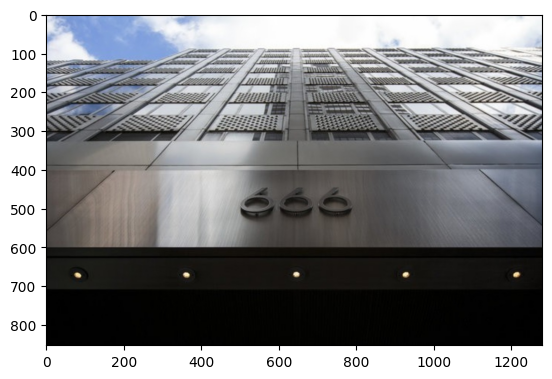

In [4]:
img = CACHE['sixes'].img
img_rgb = CACHE['sixes'].rgb()
img_gray = CACHE['sixes'].gray()

plt.imshow(img_rgb)
plt.show()

In [5]:
"""
def MSER_create(
    _delta=5,           # Intensity variation threshold
    _min_area=60,       # Minimum area of detected region
    _max_area=14400,    # Maximum area of detected region
    _max_variation=0.25,# Maximum variation between nested regions
    _min_diversity=0.2, # Minimum diversity between regions
    _max_evolution=200, # Maximum number of evolution steps
    _area_threshold=1.01,# Area threshold for pruning
    _min_margin=0.003,  # Minimum margin for pruning
    _edge_blur_size=5   # Edge blur size
):
    Creates an MSER (Maximally Stable Extremal Regions) detector with the specified parameters.
    
    MSER is a feature detection algorithm that finds connected components in an image 
    where the brightness remains stable across various threshold levels.
    
    Parameters:
    -----------
    _delta : int
        Step size between intensity thresholds. Controls how aggressively regions are merged.
        Smaller values detect more regions but are more sensitive to noise.
        Typical values: 1-10 (5 is a good default)
    
    _min_area : int
        Minimum area (in pixels) of regions to be detected.
        Used to filter out very small regions that are likely noise.
        Typical values: 30-100 depending on expected size of features
    
    _max_area : int
        Maximum area (in pixels) of regions to be detected.
        Used to filter out extremely large regions like backgrounds.
        Typical values: 5000-50000 depending on image size
    
    _max_variation : float
        Maximum variation between nested extremal regions to be considered stable.
        Lower values produce more stable regions but fewer detections.
        Range: 0-1, typical values: 0.1-0.5
    
    _min_diversity : float
        Minimum diversity between parent and child regions.
        Controls the region merging threshold based on similarity.
        Range: 0-1, typical values: 0.1-0.4
    
    _max_evolution : int
        Maximum evolution steps in the watershed algorithm.
        Limits computational complexity for very complex regions.
        Typical values: 100-300
    
    _area_threshold : float
        Rate of growth threshold for stability test.
        Areas growing faster than this rate are considered unstable.
        Typical values: 1.01-1.05
    
    _min_margin : float
        Minimum margin for region stability.
        Higher values produce more stable regions.
        Range: 0.001-0.05
    
    _edge_blur_size : int
        Size of blurring kernel for edge detection preprocessing.
        Helps reduce noise sensitivity at image edges.
        Typical values: 0-7 (0 means no blurring)
    
    Returns:
    --------
    cv2.MSER : MSER detector object
    
    Notes:
    ------
    - Input image for detectRegions() does NOT have to be grayscale, but grayscale
      is strongly recommended as MSER works based on intensity values. Color images 
      will be converted to grayscale internally, losing control over the conversion.
    
    - detectRegions() returns (regions, bboxes) where:
      - regions: list of point arrays, each containing the pixel coordinates of a region
      - bboxes: list of (x, y, width, height) tuples defining bounding rectangles
    
    - MSER works well for text detection but requires careful parameter tuning
      and post-processing to achieve good results.
    return cv2.MSER_create(
        _delta, _min_area, _max_area, _max_variation, _min_diversity,
        _max_evolution, _area_threshold, _min_margin, _edge_blur_size
    )
"""
# Initialize MSER detector.
mser = cv.MSER_create()
mser = cv2.MSER_create(
    delta=6,           # Determines stability of region (5-10 usually good)
    min_area=60,       # Minimum area of detected region (adjust based on digit size)
    max_area=2_000,    # Maximum area (adjust based on your image)
    max_variation=0.75 # Maximum variation for stability
)

In [6]:
regions, bboxes = mser.detectRegions(img_gray)

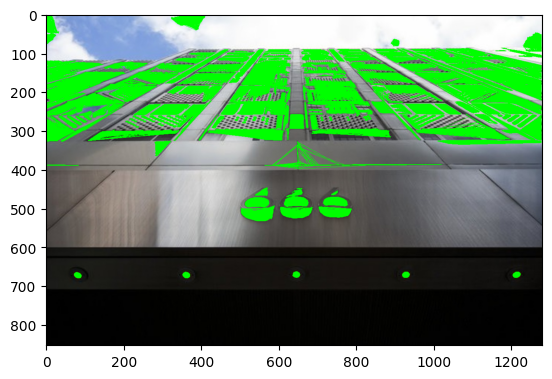

In [7]:
image_rgb = img_rgb.copy()

cv.drawContours(image_rgb, regions, -1, color=(0, 255, 0), thickness=1)

plt.imshow(image_rgb)
plt.show()

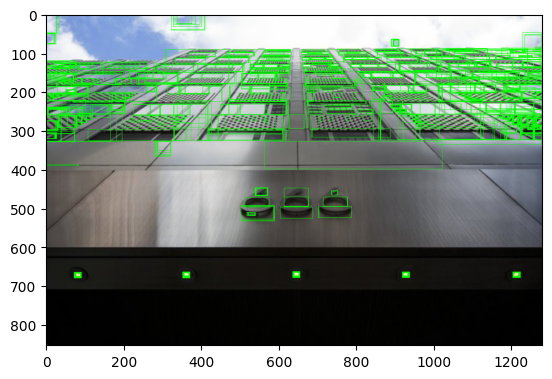

In [8]:
vis = CACHE['sixes'].img

for p in regions:
    xmax, ymax = np.amax(p, axis=0)
    xmin, ymin = np.amin(p, axis=0)
    cv2.rectangle(vis, (xmin,ymax), (xmax,ymin), (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

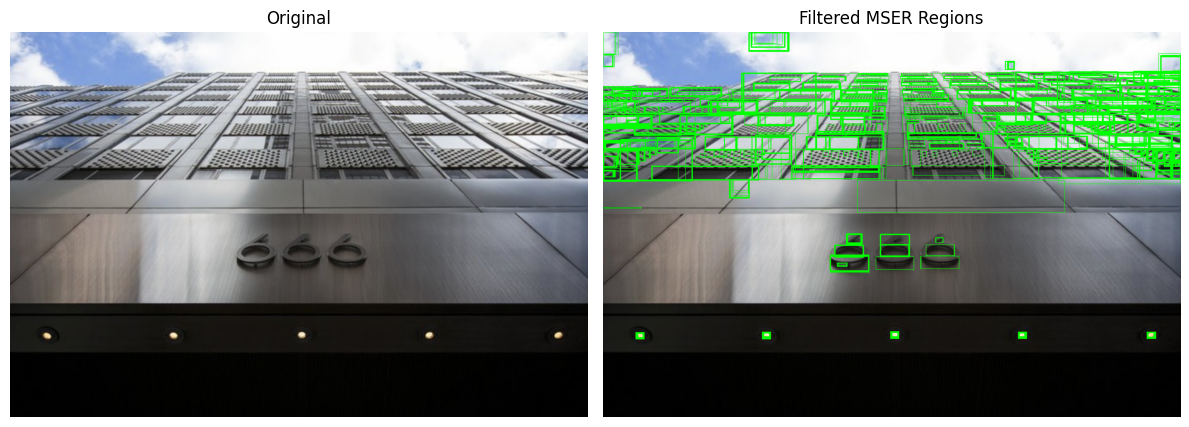

In [11]:
# Create a copy of original image for visualization
vis = img.copy()

# Filter regions based on properties that are likely to be digits
filtered_regions = []
filtered_bboxes = []
for i, region in enumerate(regions):
    # Get the bounding box
    x, y, w, h = bboxes[i]
    
    # Filter based on aspect ratio (typical for digits)
    #aspect_ratio = float(w) / h
    #if 0.1 < aspect_ratio < 5.5
        
    # Filter based on region size
    region_area = cv2.contourArea(region)
    if 1_000 < region_area < 7_000:
        # Calculate region fill ratio (compactness)
        hull = cv2.convexHull(region)
        hull_area = cv2.contourArea(hull)
        if region_area > 0 and hull_area > 0:
            fill_ratio = region_area / hull_area
            
            # Digits typically have high fill ratio
            if fill_ratio > 0.9:  # Adjust as needed
                filtered_regions.append(region)
                filtered_bboxes.append(bboxes[i])
                # Draw bounding rectangle on visualization
                cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 2)


# Display results
plt.figure(figsize=(12, 8))

# Original image
plt.subplot(121)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')

# Filtered MSER regions
plt.subplot(122)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('Filtered MSER Regions')
plt.axis('off')


plt.savefig('mser1.png')
plt.tight_layout()
plt.show()

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

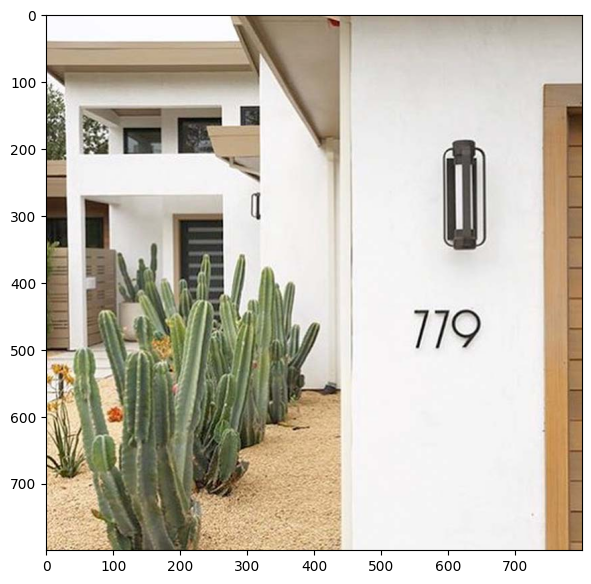

In [4]:
img = cv.imread('./cnns/img/buildings-finetune/sample1.jpg', cv.IMREAD_UNCHANGED)
img_rgb = cv.cvtColor(img, cv.COLOR_RGB2BGR)
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

plt.figure(figsize=(6, 6))

plt.imshow(img_rgb)

plt.tight_layout()
plt.show()

In [16]:
def dedup_boxes(filtered_bboxes, distance_threshold=3):
    # MSER will return a TON of duplicates.
    # So let's do a simple dedup first.
    unique_boxes = []
    seen = set()
    for box in filtered_bboxes:
        # np.ndarrays are not hashable, so we gotta make tuples out of them to dedup them.
        box_tuple = tuple(box)
        if box_tuple not in seen:
            seen.add(box_tuple)
            unique_boxes.append(box)

    print(f'unique bboxes: {len(unique_boxes)}')

    # Sort the dedup'd bboxes by area, highest to lowest.
    # We are doing this because we will give preferential treatment to larger bounding boxes
    # in the next step.
    sorted_boxes = sorted(unique_boxes, key=lambda box: box[2] * box[3], reverse=True)

    # Now we will dedup based on how close the bounding boxes are.
    deduped = {}

    # Can't use two values for a dict key so let's make something up.
    # The thing we will do is that we will favour the biggest bbox and we will use it
    # as "representative" of any other bboxes that were kinda close.
    # But we store the first bbox into the dict right away 'cas we need a non-empty
    # dict in order to have the next for loop work (can't add to the dict by iterating
    # through its items if there are no items to begin).
    dict_key = f'{sorted_boxes[0][0]},{sorted_boxes[0][1]}'
    deduped[dict_key] = sorted_boxes[0]
    
    for box in sorted_boxes:
        x, y, w, h = box
        dict_key = f'{x},{y}'
        
        # Create a list of existing keys to avoid modifying during iteration.
        # Can't (shouldn't) modify a dict while iterating through it!
        is_duplicate = False
        existing_keys = list(deduped.keys())
        for existing_key in existing_keys:
            other_box = deduped[existing_key]
            x2, y2, w2, h2 = other_box
            
            # Calculate distance between centers.
            dist = np.sqrt(np.square(x-x2) + np.square(y-y2))
            if dist < distance_threshold:
                # If the bbox is "too close" then we consider it a dup.
                # so check out the next bbox.
                is_duplicate = True
                break
        
        # If we made it here, then the distance of this bbox is far enough apart
        # from all others.
        if not is_duplicate:
            deduped[dict_key] = box

    print(f'unique bboxes that are far enough from oneanother: {len(unique_boxes)}')

    # One more deduping step!
    # This time sort based on x coords.
    deduped_boxes = sorted(list(deduped.values()), key=lambda box: box[0], reverse=True)

    # Find groups of bboxes.
    # ASSUMPTION: We want to find the group w/ the most members.
    # The most member are prob digits.
    groups = []
    current_group = [deduped_boxes[0]]
    max_distance = 150
    for i in range(1, len(deduped_boxes)):
        curr_x, curr_y = deduped_boxes[i][0], deduped_boxes[i][1]
        prev_x, prev_y = deduped_boxes[i-1][0], deduped_boxes[i-1][1]
        
        # Euclidean distance between this digit and the previous one
        distance = np.sqrt(np.square(curr_x - prev_x) + np.square(curr_y - prev_y))
        if distance <= max_distance:
            # Close enough to be part of the same number.
            current_group.append(deduped_boxes[i])
        else:
            # Too far, start a new group.
            groups.append(current_group)
            current_group = [deduped_boxes[i]]
    
    # Don't forget the last group.
    if current_group:
        groups.append(current_group)

    # Return the group with the most bounding boxes (likely to be the digits).
    largest_group = max(groups, key=len)

    # Let's add one more deduping step based on area: remove any boxes that are too different in size.
    largest_group = sorted(largest_group, key=lambda box: box[2] * box[3], reverse=True)
    comparison_box = largest_group[0]
    comparison_box_area = comparison_box[-2] * comparison_box[-1]
    deduped_by_area = []
    for box in largest_group:
        box_area = box[-2] * box[-1]
        diff = np.abs(box_area - comparison_box_area)
        tolerance = 36**2
        print(f'{box_area} - {comparison_box_area} = {diff} < {tolerance}')
        if np.abs(box_area - comparison_box_area) < tolerance:
            deduped_by_area.append( box )

    print(f'unique bboxes deduped by area: {len(deduped_by_area)}')

    # One more dedup based on building numbers not being that long.
    return deduped_by_area[:4]

In [17]:
def draw_bounding_boxes(img, scale_factor=1):
    mser = cv.MSER_create(
        delta=10,
        min_area=20*20,
        max_area=32*32,
    )
    img_rgb = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    img_gray = cv.bilateralFilter(img_gray, 5, 35, 35)
    regions, bboxes = mser.detectRegions(img_gray)
    print(f'{len(bboxes)=}')

    vis = img.copy()

    # Filter regions based on properties that are likely to be digits.
    filtered_bboxes = []
    for i, region in enumerate(regions):
        # Get the bounding box.
        x, y, w, h = bboxes[i]
        aspect_ratio = w / h
        region_area = cv.contourArea(region)
        if 0.35 < aspect_ratio < 1.5:
            filtered_bboxes.append(bboxes[i])
        cv.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 2)

    print(f'{len(filtered_bboxes)=}')
    unique_bboxes = dedup_boxes(filtered_bboxes, distance_threshold=20*scale_factor)
    print(f'{len(unique_bboxes)=}')

    #for box in filtered_bboxes:
    for box in unique_bboxes:
        x, y, w, h = box
        aspect_ratio = w / h
        area = h * w
        print(aspect_ratio, box, area/(32**2))
        cv.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 3)
        

    # Display results
    plt.figure(figsize=(12, 8))
    
    # Original image
    plt.subplot(121)
    plt.imshow(img_rgb)
    plt.title('Original')
    plt.axis('off')
    
    # Filtered MSER regions
    plt.subplot(122)
    plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title('Filtered MSER Regions')
    plt.axis('off')

    plt.savefig('mser2.png')
    plt.tight_layout()
    plt.show()
    return filtered_bboxes

In [7]:
np.sqrt(np.square(695-681) + np.square(791-781))

np.float64(17.204650534085253)

len(bboxes)=113
len(filtered_bboxes)=90
unique bboxes: 31
unique bboxes that are far enough from oneanother: 31
2508 - 2508 = 0 < 1296
1357 - 2508 = 1151 < 1296
1357 - 2508 = 1151 < 1296
unique bboxes deduped by area: 3
len(unique_bboxes)=3
0.7719298245614035 [605 441  44  57] 2.44921875
0.3898305084745763 [580 441  23  59] 1.3251953125
0.3898305084745763 [549 441  23  59] 1.3251953125


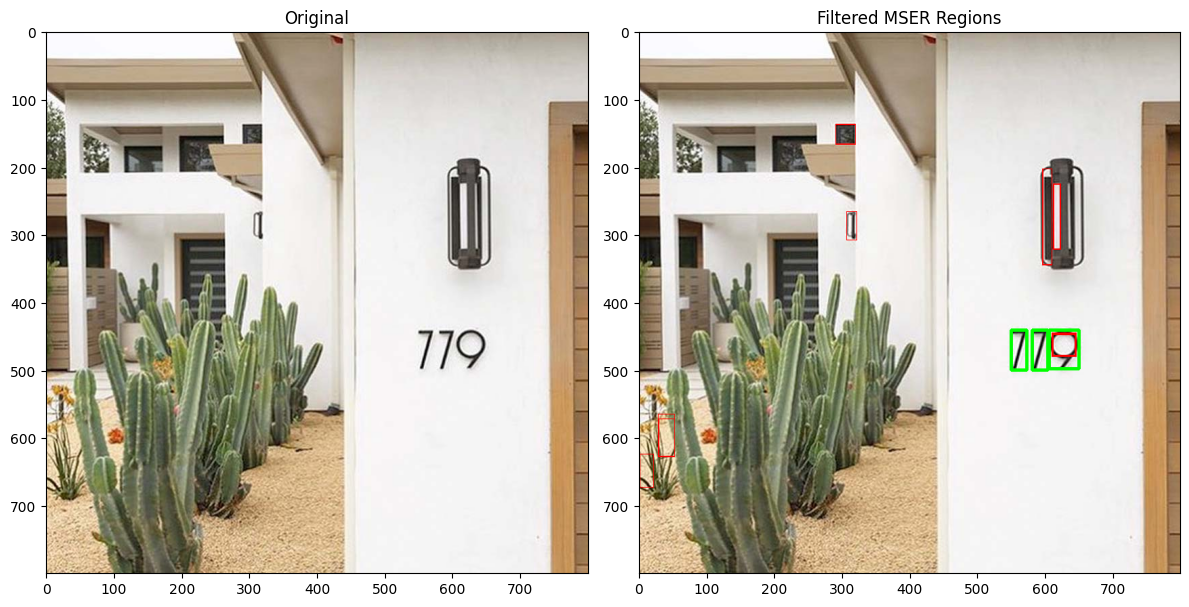

In [106]:
img = cv.imread('./cnns/img/buildings-finetune/sample1.jpg', cv.IMREAD_UNCHANGED)

filtered_boxes = draw_bounding_boxes(img)

len(bboxes)=20
len(filtered_bboxes)=20
unique bboxes: 14
unique bboxes that are far enough from oneanother: 14
2109 - 2109 = 0 < 1296
1872 - 2109 = 237 < 1296
1300 - 2109 = 809 < 1296
1274 - 2109 = 835 < 1296
unique bboxes deduped by area: 4
len(unique_bboxes)=4
0.6491228070175439 [562 757  37  57] 2.0595703125
0.6923076923076923 [682 781  36  52] 1.828125
0.4807692307692308 [618 765  25  52] 1.26953125
0.5306122448979592 [652 776  26  49] 1.244140625


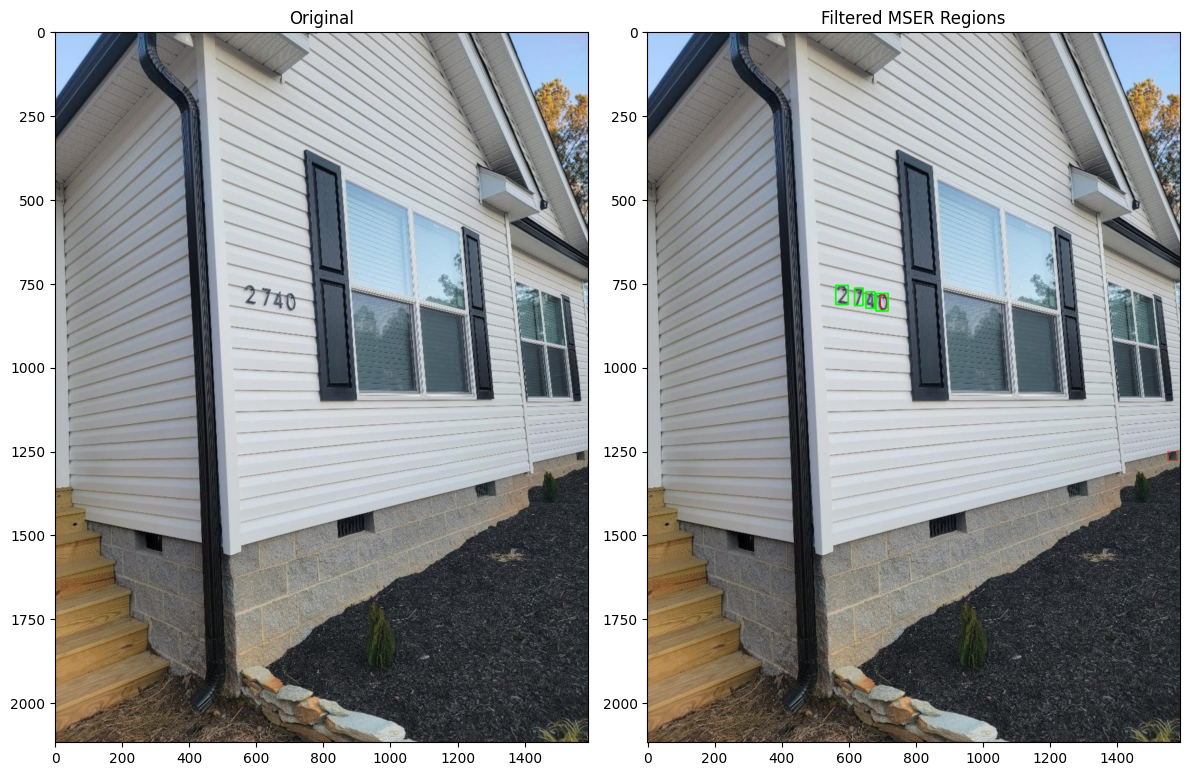

In [107]:
img = cv.imread('./cnns/img/buildings-samples/h1.jpg', cv.IMREAD_UNCHANGED)

filtered_boxes = draw_bounding_boxes(img)

len(bboxes)=142
len(filtered_bboxes)=142
unique bboxes: 38
unique bboxes that are far enough from oneanother: 38
2420 - 2420 = 0 < 1296
2006 - 2420 = 414 < 1296
2006 - 2420 = 414 < 1296
unique bboxes deduped by area: 3
len(unique_bboxes)=3
0.8 [606 319  44  55] 2.36328125
0.576271186440678 [577 336  34  59] 1.958984375
0.576271186440678 [551 351  34  59] 1.958984375


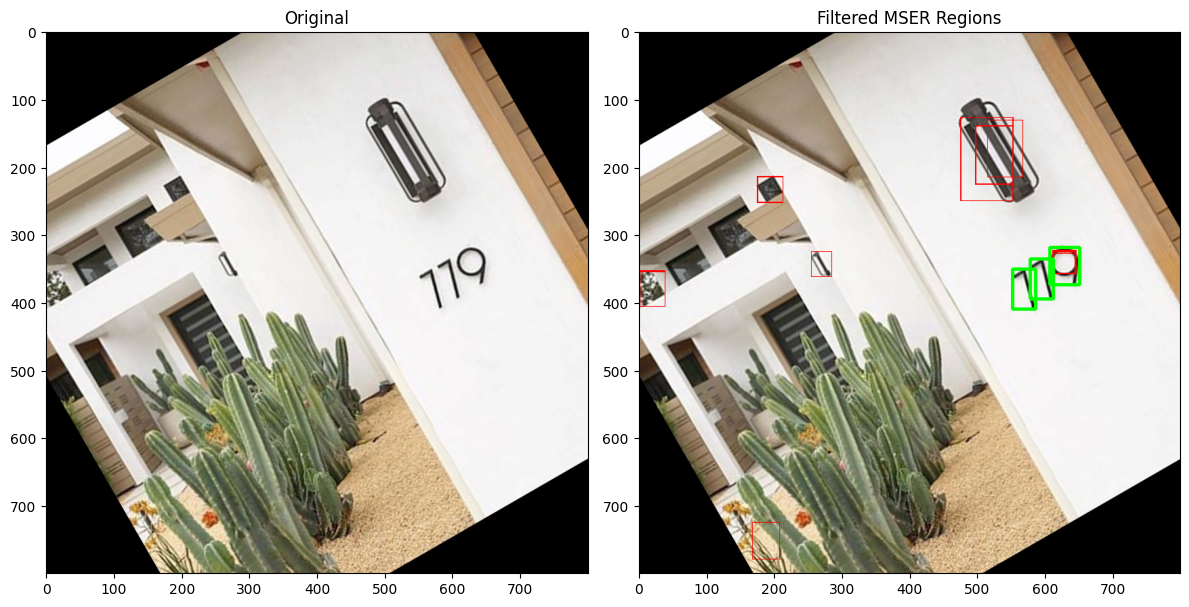

In [108]:
img = cv.imread('./cnns/img/buildings-samples/h0-rotated.jpg')

filtered_boxes = draw_bounding_boxes(img)

In [8]:
def resize_image_by_factor(image, scale_factor):
    new_height = int(image.shape[0] * scale_factor)
    new_width = int(image.shape[1] * scale_factor)

    # Choose appropriate interpolation method based on scaling direction.
    if scale_factor < 1:  # Downsampling
        interp = cv.INTER_AREA  # Better for reducing image size
    else:  # Upsampling
        interp = cv.INTER_LINEAR  # Better for increasing image size
    
    #image = cv2.bilateralFilter(image, 9, 15, 15)
    #image = cv2.filter2D(image, -1, np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]))
    # Calculate appropriate sigma based on downsampling factor.
    # Rule of thumb: sigma = factor/2
    sigma = scale_factor/2
    
    # Kernel size should be odd and roughly 6*sigma.
    # 3 sigma deviations on each side capture 99.7% of the "energy".
    kernel_size = int(6*sigma)
    if kernel_size % 2 == 0:
        kernel_size += 1
        
    # Apply Gaussian blur.
    image = cv.GaussianBlur(image, (kernel_size, kernel_size), sigma)

    return cv.resize(image, (new_width, new_height), interpolation=interp)

len(bboxes)=65
len(filtered_bboxes)=59
unique bboxes: 20
unique bboxes that are far enough from oneanother: 20
2679 - 2679 = 0 < 1296
2301 - 2679 = 378 < 1296
2184 - 2679 = 495 < 1296
1760 - 2679 = 919 < 1296
1178 - 2679 = 1501 < 1296
625 - 2679 = 2054 < 1296
unique bboxes deduped by area: 4
len(unique_bboxes)=4
0.8245614035087719 [223 135  47  57] 2.6162109375
0.6610169491525424 [272 133  39  59] 2.2470703125
0.6964285714285714 [177 136  39  56] 2.1328125
0.5818181818181818 [140 138  32  55] 1.71875


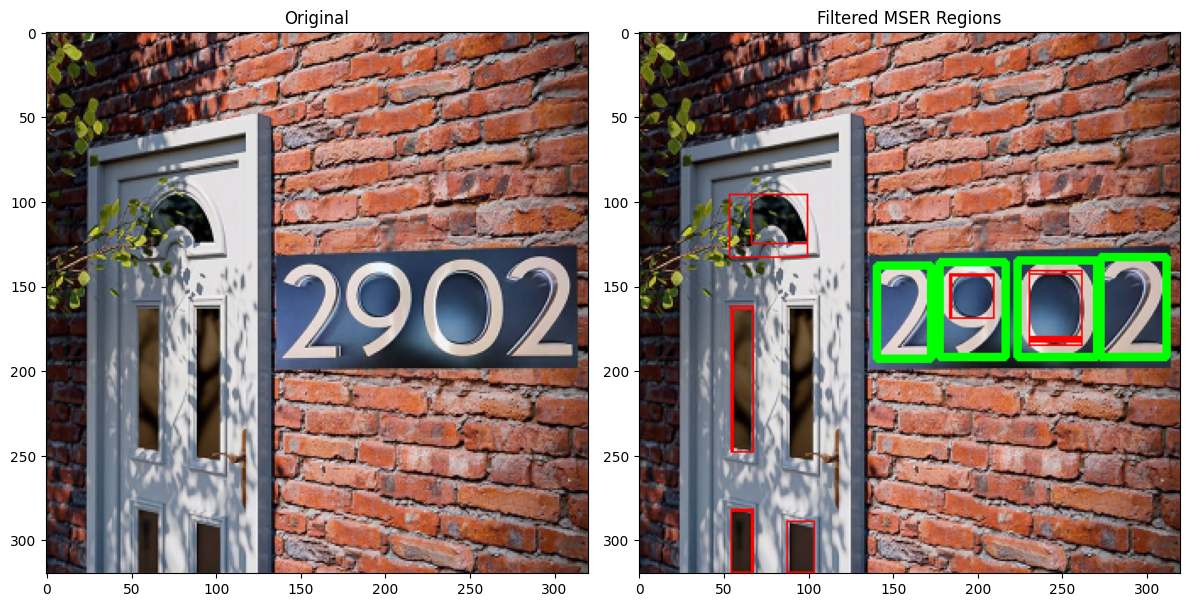

In [12]:
img = cv.imread('./cnns/img/buildings-samples/h2.jpg')

scale_factor = 1/2
img = resize_image_by_factor(img, scale_factor)

filtered_boxes = draw_bounding_boxes(img, scale_factor)

In [111]:
np.sqrt(1_300)

np.float64(36.05551275463989)

len(bboxes)=570
len(filtered_bboxes)=252
unique bboxes: 157
unique bboxes that are far enough from oneanother: 157
1333 - 1333 = 0 < 1296
1204 - 1333 = 129 < 1296
1032 - 1333 = 301 < 1296
931 - 1333 = 402 < 1296
900 - 1333 = 433 < 1296
836 - 1333 = 497 < 1296
468 - 1333 = 865 < 1296
unique bboxes deduped by area: 7
len(unique_bboxes)=4
0.7209302325581395 [ 993 1097   31   43] 1.3017578125
0.6511627906976745 [ 916 1097   28   43] 1.17578125
0.5581395348837209 [ 956 1097   24   43] 1.0078125
0.3877551020408163 [1052 1138   19   49] 0.9091796875


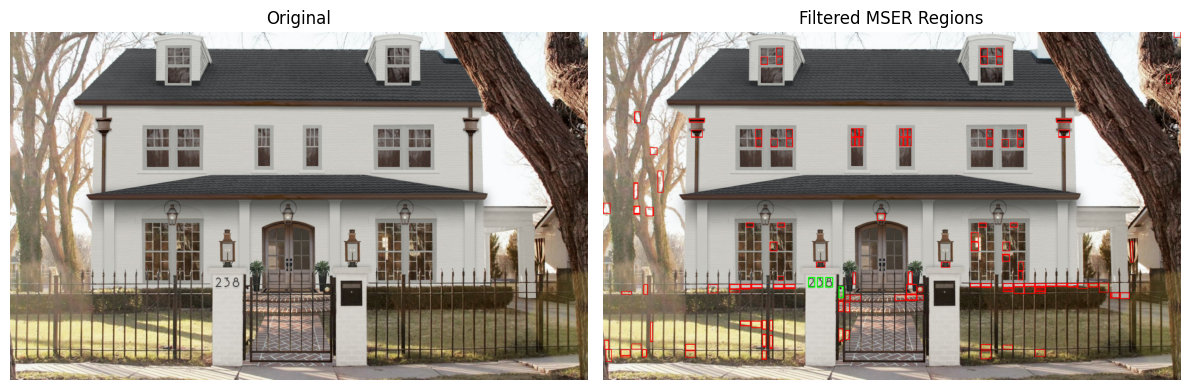

In [18]:
img = cv.imread('./cnns/img/buildings-samples/h4.jpg')

scale_factor = 1
#img = resize_image_by_factor(img, scale_factor)

filtered_boxes = draw_bounding_boxes(img, scale_factor)

len(bboxes)=141
len(filtered_bboxes)=66
unique bboxes: 44
unique bboxes that are far enough from oneanother: 44
1464 - 1464 = 0 < 1296
1320 - 1464 = 144 < 1296
1170 - 1464 = 294 < 1296
1125 - 1464 = 339 < 1296
1012 - 1464 = 452 < 1296
874 - 1464 = 590 < 1296
unique bboxes deduped by area: 6
len(unique_bboxes)=4
0.39344262295081966 [1049 1138   24   61] 1.4296875
0.6818181818181818 [ 993 1097   30   44] 1.2890625
0.5777777777777777 [ 917 1096   26   45] 1.142578125
0.5555555555555556 [ 955 1096   25   45] 1.0986328125


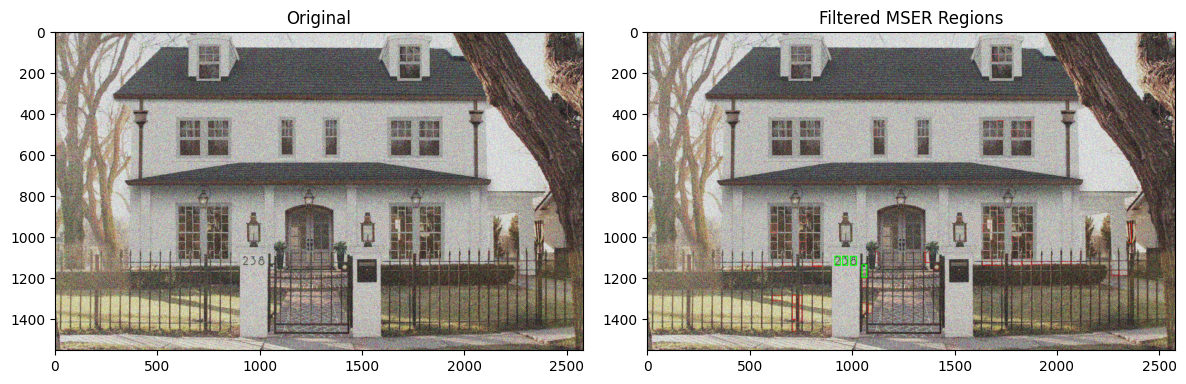

In [119]:
img = cv.imread('./cnns/img/buildings-samples/h4-noisy.jpg')

scale_factor = 1
img = resize_image_by_factor(img, scale_factor)

filtered_boxes = draw_bounding_boxes(img, scale_factor)

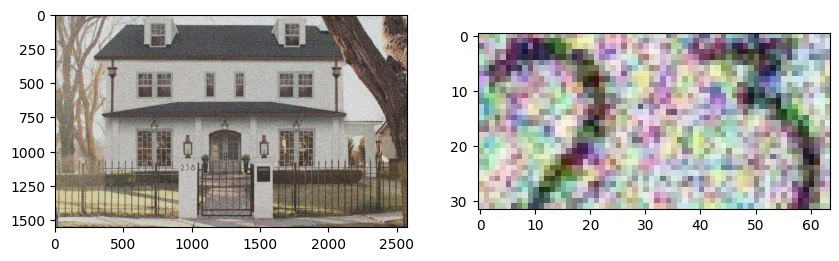

In [125]:
plt.figure(figsize=(10, 10))

y, x = 1097, 917
x += 0
size = 32

plt.subplot(121)
plt.imshow(img[:, :, ::-1])
plt.subplot(122)
plt.imshow(img[y:y+size, x:x+64, ::-1])

plt.show()

len(bboxes)=25
len(filtered_bboxes)=11
unique bboxes: 8
unique bboxes that are far enough from oneanother: 8
780 - 780 = 0 < 1296
unique bboxes deduped by area: 1
len(unique_bboxes)=1
0.8666666666666667 [1557  786   26   30] 0.76171875


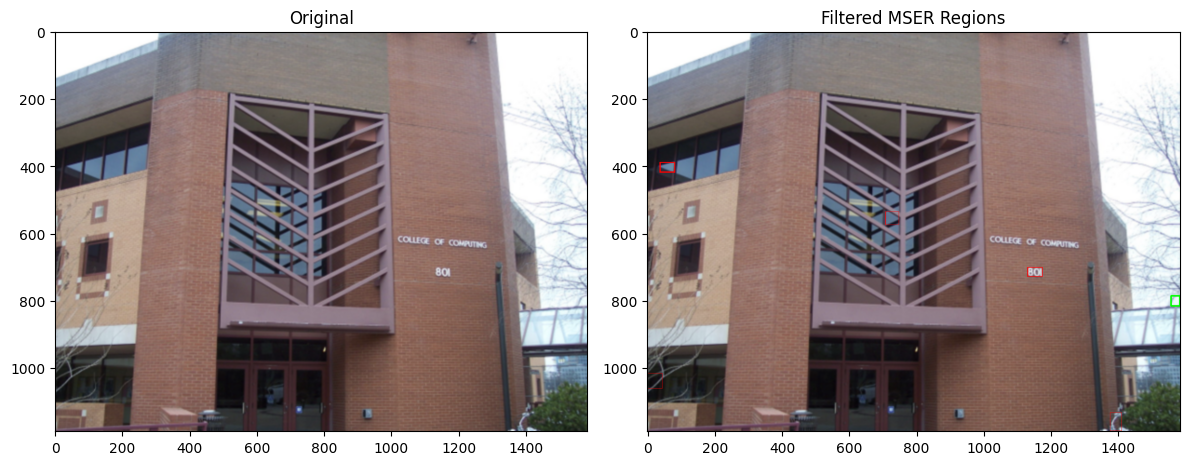

In [116]:
img = cv.imread('./cnns/img/sample1.jpg')

scale_factor = 1.5
img = resize_image_by_factor(img, scale_factor)

filtered_boxes = draw_bounding_boxes(img, scale_factor)

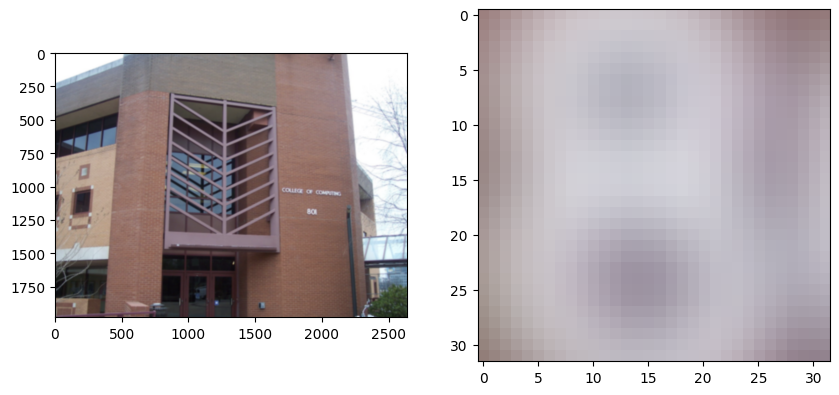

In [117]:
img = cv.imread('./cnns/img/sample1.jpg')
scale_factor = 2.5
img = resize_image_by_factor(img, scale_factor)

plt.figure(figsize=(10, 10))

y, x = 1_175, 1_885
x += 46 * 0
size = 32 * 1

plt.subplot(121)
plt.imshow(img[:, :, ::-1])
plt.subplot(122)
plt.imshow(img[y:y+size, x:x+size, ::-1])

plt.show()